Importando as bibliotecas


In [2]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from matplotlib import pyplot as plt
from random import randrange


In [3]:
def fetch_dataset(filename: str):
    return np.array(pd.read_csv(filename, header=0))

#### Auxiliar functions

In [4]:
def my_centers(samples, n_of_centers : int) -> np.ndarray:
    """Retorna centros aleatórios baseados na localização dos dados"""
    centers, points_used = [], []
    sample_size = len(samples)
    i = 0

    while i < n_of_centers:
        new_center = randrange(sample_size)
        if new_center not in points_used: # check if the random point hasn't been chosen
            points_used.append(new_center)
            centers.append(samples[new_center])
            i += 1

    return np.array(centers)


def distance(sample, center):
    return la.norm(sample - center)


def find_minimal_distance(point, centers):
    """Retorna o índice do centro mais próximo de um ponto."""
    min_pos = 0
    min_dist = distance(point, centers[0])

    for i in range(1, len(centers)):
        new_dist = distance(point, centers[i])
        if new_dist < min_dist:
            min_dist = new_dist
            min_pos = i
    return min_pos, min_dist

def vector_mean(data: np.ndarray) -> np.ndarray:
    """Calcula a média de um numpy.ndarray."""
    acc = [0] * len(data[0])
    for i in data:
        acc += i
    return np.array(acc) / len(data)


def demean(data: np.ndarray) -> np.ndarray:
    """"Subtrai a média de cada elemento de um numpy.ndarray de um outro numpy.ndarray."""
    return data - vector_mean(data)


def covariance(data: np.ndarray) -> np.ndarray:
    """Retorna a matriz de covariância de uma matriz de dados"""
    return (1 / (len(data) - 1)) * np.dot(data.T, data)


def order_vectors(values: np.array, vectors: np.matrix):
    """Ordena os autovetores de acordo com os autovalores."""
    values_order = np.argsort(values)[::-1]  # indexes on reverse order
    return values[values_order], vectors[:, values_order] # return the sorted values and vectors

Função K-means


In [5]:
def my_kmeans(samples, n_of_centers : int, max_iteration: int = 1000, epsilon: float = 0.0001):
    """Algoritmo de K-means."""
    # adquire os centros dos clusters
    centers = my_centers(samples, n_of_centers)
    # inicia a separacao dos pontos em clusters
    n_of_samples = len(samples)
    over = False
    iterations = 0

    while not over and iterations < max_iteration:
        cluster_sum = [0] * n_of_centers
        cluster_number_points = [0] * n_of_centers

        # encontra a distancia minima e soma a distancia no respectivo cluster
        for i in range(n_of_samples):
            min = find_minimal_distance(samples[i], centers)
            cluster_sum[min[0]] += samples[i]
            cluster_number_points[min[0]] += 1

        # calcula a media de cada cluster e modifica os centros
        prev_center = centers.copy()
        for i in range(n_of_centers):
            if cluster_number_points[i] != 0:
                centers[i] = np.array(cluster_sum[i] / cluster_number_points[i])

        # calcula a diferenca dos centros com a interacao anterior
        diff_norm = 0
        for i in range(n_of_centers):
            diff_v = centers[i] - prev_center[i]
            diff_norm += la.norm(diff_v)

        # verifica se os centros foram muito alterados, senao encerra o algoritmo
        if diff_norm < epsilon:
            over = True
            break

        iterations += 1

    return centers


In [6]:
def k_elbow(sample, centers : int = 17):
    """Retorna o número de clusters mais adequado para a sample."""
    # inicializacao de variaveis
    squared_distance = [0] * (centers - 2)
    k = 2  # numero de centers

    # laço de repetição de k centers
    while k < centers:
        centroids = my_kmeans(sample, k)
        i = 0
        sqr_dist_sum = 0
        # laço de repetição para calcular a soma do quadrado das distancias
        while i < len(sample):
            aux = find_minimal_distance(sample[i], centroids)
            sqr_dist_sum += aux[1] ** 2
            i += 1
        squared_distance[k - 2] = sqr_dist_sum
        k += 1

    # variaveis para plotar o grafico
    n_clusters = np.zeros([centers - 2])
    h = 0
    while h < centers - 2:
        n_clusters[h] = h + 2
        h += 1

    return n_clusters, squared_distance


In [7]:
def PCA(data, n : int = 2):
    demeaned = demean(data)
    cov_matrix = covariance(demeaned)
    eig_val, eig_vec = np.linalg.eig(cov_matrix)
    eig_val, eig_vec = order_vectors(eig_val, eig_vec)
    return demeaned @ eig_vec[:, :n]
    


# Loading data

In [8]:
file = "https://raw.githubusercontent.com/G-Nozawa/K-Means-Elbow-method/main/dados/dados_parte_1.csv"
data = fetch_dataset(file)

### K-Elbow

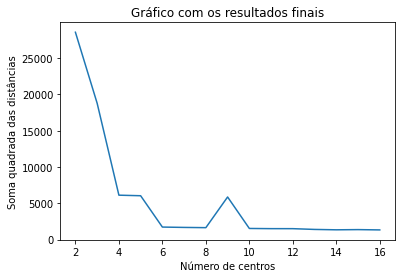

In [17]:
x, y = k_elbow(data, 17)

plt.title("Gráfico com os resultados finais")
plt.xlabel("Número de centros")
plt.ylabel("Soma quadrada das distâncias")
plt.plot(x, y)
plt.show()

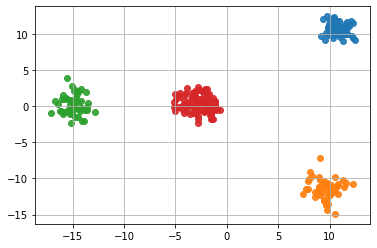

In [19]:

n = int(input("Digite o número de centros: "))

centers = my_kmeans(data, n)
labels = []
for i in range(len(data)):
    labels.append(find_minimal_distance(data[i], centers)[0])
labels = np.array(labels).reshape((-1, 1))

data_label = np.hstack((data, labels))

pca_result = PCA(data)
pca_clusters = []

for i in range(n):
    sum = []
    for d in range(len(pca_result)):
        if (labels[d] == i):
            sum.append(pca_result[d])
    sum = np.vstack(sum)
    pca_clusters.append(sum)

for i in range(n):
      plt.scatter(pca_clusters[i][:,0], pca_clusters[i][:,1], alpha=0.9, label=i)
plt.grid("true")